Librerias que serán utilizadas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline

Funcion para calcular los puntos de cruce.

In [2]:
## Tomada de:
## https://stackoverflow.com/questions/10475488/calculating-crossing-intercept-points-of-a-series-or-dataframe
def cross(series, cross=0, direction='cross'):
    """
    Given a Series returns all the index values where the data values equal 
    the 'cross' value. 

    Direction can be 'rising' (for rising edge), 'falling' (for only falling 
    edge), or 'cross' for both edges
    """
    # Find if values are above or bellow yvalue crossing:
    above=series.values > cross
    below=np.logical_not(above)
    left_shifted_above = above[1:]
    left_shifted_below = below[1:]
    x_crossings = []
    # Find indexes on left side of crossing point
    if direction == 'rising':
        idxs = (left_shifted_above & below[0:-1]).nonzero()[0]
    elif direction == 'falling':
        idxs = (left_shifted_below & above[0:-1]).nonzero()[0]
    else:
        rising = left_shifted_above & below[0:-1]
        falling = left_shifted_below & above[0:-1]
        idxs = (rising | falling).nonzero()[0]

    # Calculate x crossings with interpolation using formula for a line:
    x1 = series.index.values[idxs]
    x2 = series.index.values[idxs+1]
    y1 = series.values[idxs]
    y2 = series.values[idxs+1]
    x_crossings = (cross-y1)*(x2-x1)/(y2-y1) + x1

    return x_crossings

Haz una lista de los archivos de datos

In [3]:
archivos = glob('datos/*')
print(archivos)

['datos/teste-2017-10-06-16:20.csv', 'datos/teste-2017-10-06-16:19.csv', 'datos/teste-2017-10-06-18:06.csv']


Lee el archivo e identifica el tiempo como indice.

In [4]:
df = pd.read_csv('datos/teste-2017-10-06-18:06.csv')
df = df[:-1]
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
#df.tail()

Para 1 fase utilicé un cable que multiplica la corriente x 10.

In [5]:
if len(df.columns) == 1:
    df['I'] = df.I.values * 0.1
else:
    df['I'] = df[['A1', 'A2', 'A3']].mean(axis=1)

Calculo de los tiempos de encendido y apagado.

In [6]:
xr = cross(df.I, cross=0.5, direction='rising')
print(xr)
xf = cross(df.I, cross=0.5, direction='falling')
print(xf)

['2017-10-06T20:33:43.250465570' '2017-10-07T00:19:41.971453104'
 '2017-10-07T04:24:07.725146550' '2017-10-07T07:50:52.302200023'
 '2017-10-07T10:59:59.247413193' '2017-10-07T15:00:52.615781850'
 '2017-10-07T18:24:51.110525528' '2017-10-07T22:20:22.961563441'
 '2017-10-08T02:50:14.826399946']
['2017-10-06T23:06:47.649324757' '2017-10-07T01:49:05.963590674'
 '2017-10-07T06:12:12.778798932' '2017-10-07T09:23:25.187681930'
 '2017-10-07T12:37:32.756030230' '2017-10-07T16:24:28.215745497'
 '2017-10-07T20:27:16.425222972' '2017-10-08T00:29:08.904726971']


Consumos en vacio y el pico más alto.

In [7]:
consumo_sin_compresor = df[10000:28000].I.mean()
print('El consumo sin el compresor es de {:.8f} A'.format(consumo_sin_compresor))
imax = df.I.max()
print('El pico más alto en corriente es {:.2f} A'.format(imax))

El consumo sin el compresor es de 0.04190982 A
El pico más alto en corriente es 5.73 A


Gráfica del consumo.

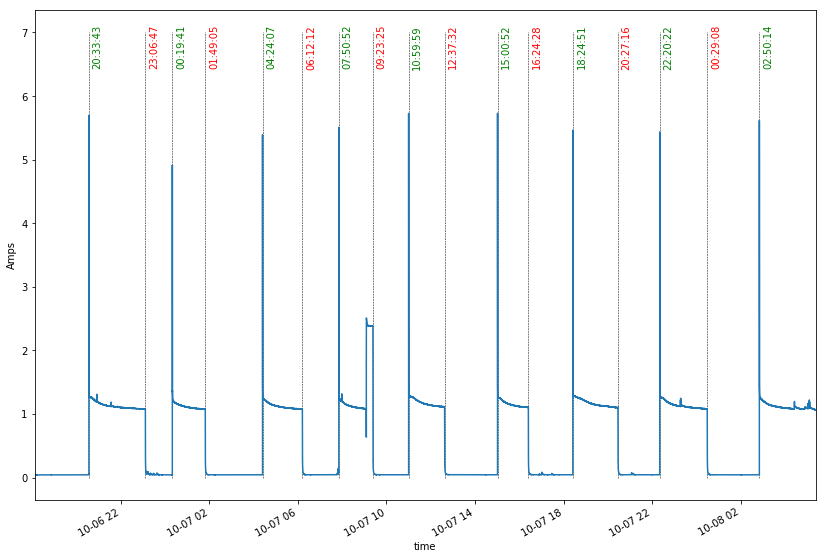

In [8]:
fig = plt.figure(figsize=(14,10))
plt.xlabel('Tiempo')
plt.ylabel('Amps')
for x in xr:
    plt.plot([x,x],[0,7], 'k--', linewidth=0.5)
    plt.text(x+ np.timedelta64(600, 's'),7,str(x).split('.')[0].split('T')[1], rotation='vertical', color='green')
for x in xf:
    plt.plot([x,x],[0,7], 'k--', linewidth=0.5)
    plt.text(x+ np.timedelta64(600, 's'),7,str(x).split('.')[0].split('T')[1], rotation='vertical', color='red')
df.I.plot()
#plt.vlines(xr, 0,7)
plt.show()

Integración para obtener el consumo total en energía.

In [9]:
datos = df.copy()
datos.index = datos.index - datos.index[0] # Hace que el tiempo inicie en cero
datos.index = datos.index / np.timedelta64(1, 's') # Tiempo a segundos

eng_total = np.trapz(df.I.values, x=datos.index) * 110 # volts x ampere x s
kWh = eng_total / 3600000 # 3600 seg en una hora, 1000 W en un kW
kWh

tiempo = datos.tail(1).index[0] / 60 / 60 / 24
print('Se consumieron {:.2f} kWh en {:.2f} dias'.format(kWh, tiempo))
print('Esto equivale a {:.2f} kWh en un bimestre'.format(kWh / tiempo * 60)) # Consumo por día x 60 días.

Se consumieron 2.28 kWh en 1.47 dias
Esto equivale a 92.94 kWh en un bimestre
